# 14.5 点集合に対するボロノイ図の計算
　母点の集合に対する**ボロノイ図**は、空間をいくつかの領域に分割する。領域内のあらゆる点は、1つの母点に対して他の母点よりも近くに存在するという特徴がある。  
　ボロノイ図は、計算幾何学の基本的な構造であり、計算機科学、ロボット工学、地理学など多くの分野で広く活用されている。例えば地下鉄の駅に対するボロノイ図は、最も近い駅を示す。  
　このレシピでは、パリ市内の地下鉄駅に対するボロノイ図をSciPyを使って作成する。

## 準備
　パリのOpenStreetMap地図を表示するために、Smopyモジュールを使う。
 ```python
 pip install smopy
 ```
　加えて、[本書のGitHubリポジトリ](https://github.com/ipython-books/cookbook-data)からRATPデータセットをダウンロードして、カレントディレクトリに展開する。このデータは、RATP(パリ交通公団)オープンデータWebサイトから入手したものである。

## 手順
1. NumPy、pandas、matplotlib、SciPyをインポートする。

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
%matplotlib inline

1. データセットをpandasに読み込む。

In [2]:
df = pd.read_csv('data/ratp.csv', sep='#', header=None)

In [3]:
df[df.columns[1:]].tail(2)

,1,2,3,4,5
11609,2.301197,48.933118,TIMBAUD,GENNEVILLIERS,tram
11610,2.230144,48.913708,VICTOR BASCH,COLOMBES,tram


1. このDataFrameオブジェクトには座標、名称、市、行政区、駅の種類が記録されている。この中から地下鉄の駅をすべて取り出す。

In [4]:
metro = df[(df[5] == 'metro')]

In [5]:
metro[metro.columns[1:]].tail(3)

,1,2,3,4,5
305,2.308041,48.841697,Volontaires,PARIS-15EME,metro
306,2.379884,48.857876,Voltaire (Léon Blum),PARIS-11EME,metro
307,2.304651,48.883874,Wagram,PARIS-17EME,metro


1. 行政区番号を取り出す。pandasでは対象列のstr属性を通して文字列演算子を配列に対して適用できる。

In [6]:
# パリ市内の駅か否かを判定
paris = metro[4].str.startswith('PARIS').values

In [7]:
# 駅かパリ市にある場合は行政区番号を、ない場合には0を値とする行列を作成
districts = np.zeros(len(paris), dtype=np.int32)
districts[paris] = metro[4][paris].str.slice(6,8).astype(np.int32)
districts[~paris] = 0
ndistricts = districts.max() + 1

1. すべての地下鉄駅の座標も取り出す。

In [8]:
lon = metro[1]
lat = metro[2]

1. 次にOpenStreetMapからパリの地図を取り出す。地下鉄駅の緯度経度の最大値と最小値を使って範囲を指定する。地図の生成には、軽量なSmopyモジュールを使用する。

In [9]:
box = (lat[paris].min(), lon[paris].min(), lat[paris].max(), lon[paris].max())
m = smopy.Map(box, z=12)

1. SciPyを使ってボロノイ図を計算する。各地点の座標からVoronoiオブジェクトを生成する。オブジェクトには、可視化の際に使用する属性が含まれる。

In [10]:
vor = spatial.Voronoi(np.c_[lat, lon])

1. ボロノイ図を表示する汎用の関数を作成する。SciPyは同じ機能を既に実装しているが、扱える地点数に制限がある。そこで、Stack Overflow (http://stackoverflow.com/a/20678647/1595060) に公開されていたものを使用する。

In [13]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a 
    2D diagram to finite regions.
    Source: http://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, 
                                  vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

1. voronoi_finite_polygons_2d()関数は領域のリスト(regions)と頂点のリスト(vertices)を返す。領域は頂点のインデックスをリストしたものである。頂点の座標はverticesに格納されている。これらのデータからセルのリスト(cells)を作成する。セルは、頂点座標の配列で構成される多角形である。また、緯度と経度を地図上のピクセル一に変換するsmopy.Mapのto_pixels()関数を使う。

In [12]:
regions, vertices = voronoi_finite_polygons_2d(vor)
cells = [(vertices[region]) for region in regions]

1. 各多角形の表示にどの色を使うか計算する。

In [14]:
cmap = plt.cm.Set3
# カラーマップを使い、行政区ごとの色を生成する
colors_districts = cmap(np.linspace(0., 1., ndistricts))[:,:3]
# 各多角形を彩色する。デフォルトは灰色
colors = .25 * np.ones((len(districts), 3))
# 各多角形を行政区ごとの色で塗り分ける
colors[paris] = colors_districts[districts[paris]]

1. 最後に、地図とボロノイズをMapインスタンスのshow_mpl()関数を使って表示する。

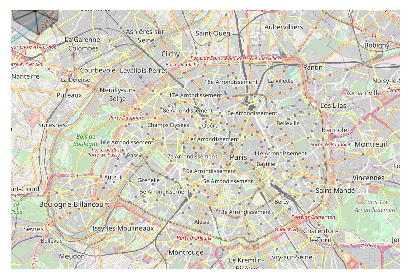

In [15]:
ax = m.show_mpl()
ax.add_collection(mpl.collections.PolyCollection(cells, facecolors=colors, edgecolors='k', alpha=0.35,))

## 解説
　ユークリッド空間におけるボロノイ図の数学的定義を与える。($x_i$)が点の酒豪だとして、この点集合のボロノイ図は、次の式で定義される$V_i$(**セル**または**領域**)の集合である。
$$ V_i = \{x \in {\bf R} \mid \forall j \neq i, \parallel x-x_i \parallel \le \parallel x-x_j \parallel \}$$
　ボロノイ図の双対グラフが**ドロネー三角形分割**である。この幾何図形オブジェクトは、点集合の凸包を三角形で覆う。SciPyでは、C++の計算機科学ライブラリであるQhullを使ってボロノイ図を計算する。